# Gaussian Process Latent Variable Models


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import tensorflow as tf
from tqdm.autonotebook import tqdm
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk
%pylab inline

sns.set_context('talk',font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
def reset_session():
  """Creates a new global, interactive session in Graph-mode."""
  global sess
  try:
    tf.reset_default_graph()
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

reset_session()

## Load fashion-MNIST Data

In [0]:
(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
N = 1000
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

## Variables entrenables

In [0]:
# Variables entrenables
amplitude = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='amplitude',
                    dtype=tf.float64,
                    initializer=np.float64(1.)))

length_scale = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='length_scale',
                    dtype=tf.float64, 
                    initializer=np.float64(1.)))

observation_noise_variance = np.finfo(np.float64).eps + tf.nn.softplus(
    tf.get_variable(name='observation_noise_variance',
                    dtype=tf.float64, 
                    initializer=np.float64(1.)))

In [0]:
observations_ = small_x_train.reshape(N, -1).transpose()

init_ = np.random.normal(size=(N, 2))
latent_index_points = tf.get_variable(
    name='latent_index_points',
    dtype=tf.float64,
    initializer=init_)

## Modelo y entrenamiento

In [6]:

kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=latent_index_points,
    observation_noise_variance=observation_noise_variance)


log_probs = gp.log_prob(observations_, name='log_prob')

loss = -tf.reduce_mean(log_probs)
optimizer = tf.train.AdamOptimizer(learning_rate=.1)
train_op = optimizer.minimize(loss)

W0828 18:36:15.480376 139813786109824 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1205: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Construct predictive model and sampling ops

In [0]:

sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)

grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=grid_,
    observation_index_points=latent_index_points,
    observations=observations_)

samples = gprm.sample()

## Entrenar y conseguir embeddings

In [11]:
sess.run(tf.global_variables_initializer())
num_iters = 100
log_interval = 20
lips_ = np.zeros((num_iters, N, 2), np.float64)
pbar = tqdm(range(num_iters))
for i in pbar:
  _, loss_, lips_[i] = sess.run([train_op, loss, latent_index_points])
  pbar.set_postfix({'loss':loss_})

## Resultados

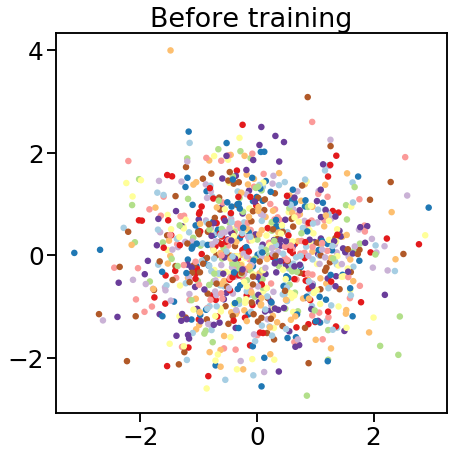

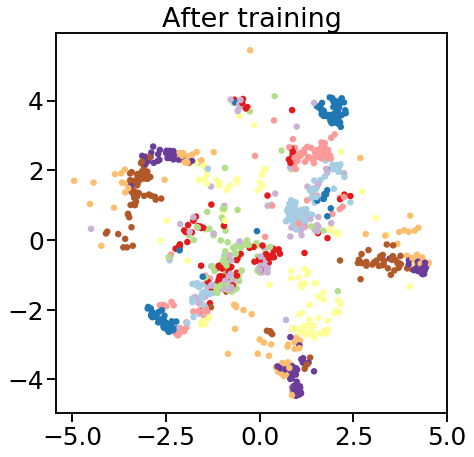

In [13]:
plt.figure(figsize=(7, 7))
plt.title("Before training")
plt.grid('off')
plt.scatter(x=init_[:, 0], y=init_[:, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=25)
plt.show()

plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid('off')
plt.scatter(x=lips_[-1, :, 0], y=lips_[-1, :, 1],
           c=y_train[:N], cmap=plt.get_cmap('Paired'), s=25)
plt.show()

## Samplear nuestro espacio 

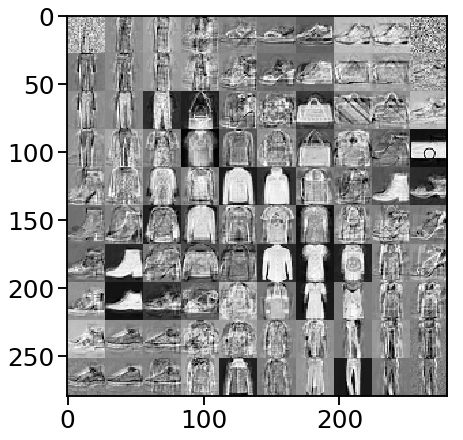

In [14]:
samples_ = sess.run(samples)

samples_ = np.squeeze(samples_)
samples_ = ((samples_ -
             samples_.min(-1, keepdims=True)) /
            (samples_.max(-1, keepdims=True) -
             samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid('off')
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()